# **Оптимизация производительности системы автоматического распознавания вооружения в видеопотоке путём нейросетевого сжатия весов с использованием библиотеки NeuZip**

# Клонирование репозитория

Клонируем репозиторий, устанавливаем зависимости

In [ ]:
!git clone https://github.com/kcherenkovv/neuzip

fatal: destination path 'neuzip' already exists and is not an empty directory.


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


# Загрузка и анализ датасета

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Распаковка датасета

In [ ]:
!unzip -u "/content/drive/MyDrive/dataset1.zip" -d "/content/"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/dataset/labels/test/smartphone_1006.txt  
  inflating: /content/dataset/labels/test/billete_2350.txt  
  inflating: /content/dataset/labels/test/img483.txt  
  inflating: /content/dataset/labels/test/pistol_9003.txt  
  inflating: /content/dataset/labels/test/pistol_9002.txt  
  inflating: /content/dataset/labels/test/img1733v2.txt  
  inflating: /content/dataset/labels/test/KravMagaKnifeDefenseTechniques288.txt  
  inflating: /content/dataset/labels/test/ABsframe00010.txt  
  inflating: /content/dataset/labels/test/knife_886.txt  
  inflating: /content/dataset/labels/test/knife_1168.txt  
  inflating: /content/dataset/labels/test/smartphone_1007.txt  
  inflating: /content/dataset/labels/test/knife_150.txt  
  inflating: /content/dataset/labels/test/DefenseKnifeAttack0451.txt  
  inflating: /content/dataset/labels/test/knife_1332.txt  
  inflating: /content/dataset/labels/test/pistol_5000.txt  
 

# Анализ датасета

Этот датасет состоит из 5678 изображений, каждое из которых имеет аннотации в формате .txt. Включает 6 классов объектов: пистолет (pistol), смартфон (smartphone), нож (knife), кошелек (wallet), купюра (bill), карта (card).

Датасет является результатом объединения общедоступных материалов и данных, предоставленных компанией [Арсенал+](https://arsplus.ru/).

Конфигурация датасета (пути к изображениям, классам) хранится в файле dataset.yaml.

In [ ]:
!cp /content/neuzip/check_dataset.py /content/

In [ ]:
!python3 check_dataset.py


Обработка train...

Обработка test...

Image Size Analysis:
  Min Width: 130, Max Width: 4000
  Min Height: 82, Max Height: 3456
  Avg Width: 1174.03, Avg Height: 755.59

Class Distribution:
  pistol: 1437 (25.31%)
  smartphone: 681 (11.99%)
  knife: 2277 (40.10%)
  wallet: 559 (9.85%)
  bill: 451 (7.94%)
  card: 273 (4.81%)

Final Report:
  Всего изображений: 5678
  Всего аннотаций: 5678
  Всего объектов: 5678
  Удалено изображений: 0
  Удалено аннотаций: 0


**Результаты анализа** датасета хорошие.

Также важно отметить баланс классов:
* Доля ножей и пистолетов: Они составляют 65.41% от всех объектов, что означает, что датасет достаточно сильно представлен этими классами. Это хорошо для нашей основной задачи, а именно детекции вооружения (пистолет, нож)

* Балансировка внутри вспомогательных классов: Вспомогательные классы (wallet, bill, card, smartphone) имеют относительно равномерное распределение, хотя smartphone немного доминирует (34.67%). Это может быть нормально, если мы не ожидаем, что модель будет путать пистолеты и ножи именно с smartphone.

* Размеры изображений: Размеры изображений сильно варьируются

Примеры изображений из тестовой выборки

Размер изображения: (1280, 720)
Аннотации найдены: /content/yolov5/dataset/labels/train/pistol_5066.txt
Строка аннотации: class_id=0.0, x_center=0.546484375, y_center=0.44027777777777777, width=0.17578125, height=0.13055555555555556
Bounding box: x_min=587, y_min=270, x_max=812, y_max=364
Рисую bounding box: x_min=587, y_min=270, x_max=812, y_max=364


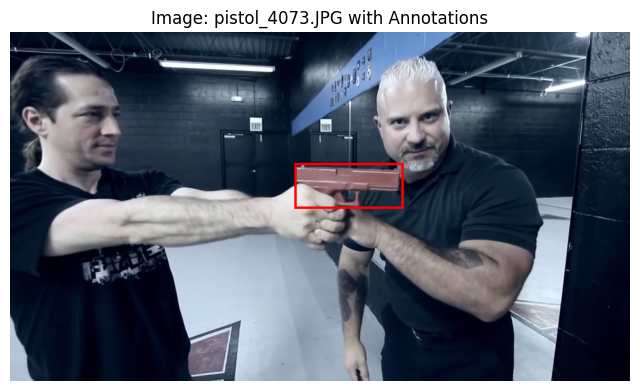

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

# Путь к конкретному изображению и аннотации
image_path = "/content/yolov5/dataset/images/train/pistol_5066.jpg"
label_path = "/content/yolov5/dataset/labels/train/pistol_5066.txt"

# Загрузка изображения
img = Image.open(image_path)
draw = ImageDraw.Draw(img)

# Отладочный вывод размера изображения
img_width, img_height = img.size
print(f"Размер изображения: {img.size}")

# Чтение аннотаций
if os.path.exists(label_path):
    print(f"Аннотации найдены: {label_path}")
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.split())
            print(f"Строка аннотации: class_id={class_id}, x_center={x_center}, y_center={y_center}, width={width}, height={height}")

            # Преобразование координат YOLO в пиксели
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)

            print(f"Bounding box: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")

            # Рисование bounding box
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=5)
            print(f"Рисую bounding box: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")
else:
    print(f"Файл аннотаций не найден: {label_path}")

# Отображение изображения
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title("Image: pistol_4073.JPG with Annotations")
plt.axis('off')
plt.show()

# 3. Обучение различных версий Yolo

# Yolov8

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
!yolo train model=yolov8n.pt data=/content/dataset/dataset.yaml epochs=30 imgsz=640 batch=-1 device=0 amp=True

Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/dataset/dataset.yaml, epochs=30, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

## Детекция на тестовых данных

In [ ]:
# Для оригинальной PyTorch-модели
!yolo predict \
    model=/content/model_8v_optimized_nz.onnx \
    source=/content/dataset/images/test \
    conf=0.5 \
    name=original_predict

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics 8.3.120 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/model_8v_optimized_nz.onnx for ONNX Runtime inference...
requirements: Ultralytics requirements ['onnx', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 346.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 280.5 MB/s eta 0:00:00
   ━━━━━━━━━━

## Экспорт в формат ONNX

In [ ]:
!yolo export \
    model=/content/model/content/runs/detect/train2/weights/best.pt \
    format=onnx \
    imgsz=640,640 \
    simplify=True \
    opset=12 \
    dynamic=False \

Ultralytics 8.3.113 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/model/content/runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (5.9 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 1.2s, saved as '/content/model/content/runs/detect/train2/weights/best.onnx' (11.7 MB)

Export complete (1.7s)
Results saved to /content/model/content/runs/detect/train2/weights
Predict:         yolo predict task=detect model=/content/model/content/runs/detect/train2/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/model/content/runs/detect/train2/weights/best.onnx imgsz=640 data=/content/dataset/dataset.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export


## Оптимизация модели с помощью библиотеки Neuzip

Оптимизация модели производится на облачном сервере, который арендуется на сервисе [Immers cloud](https://immers.cloud/).
На основе предоставленной конфигурации облачного сервера (Tesla A100, 16 vCPU, 64 GB RAM, 160 GB Disk, Ubuntu 22.04.4, CUDA 12.3).
Далее было создано следующее виртуальное окружение:
* Python version: 3.10
* PyTorch version: 2.1.0
* CUDA version: 12.4
* NumPy version: 2.1.2
* Torchvision 0.16.0
* tqdm 4.66.1
* Pillow 10.1.0
* requests 2.31.0
* scikit-learn 1.3.2
* matplotlib 3.8.0
* opencv-python 4.8.1.78

In [ ]:
%pip install neuzip

  Using cached neuzip-0.1.1.tar.gz (16 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for neuzip (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for neuzip
Failed to build neuzip
ERROR: Failed to build installable wheels for some pyproject.toml based projects (neuzip)


In [ ]:
!python model_optimization_neuzip.py /models/model_8v.onnx --output_model /path/to/optimized/model_8v_optimized_nz.onnx

Пример детекции

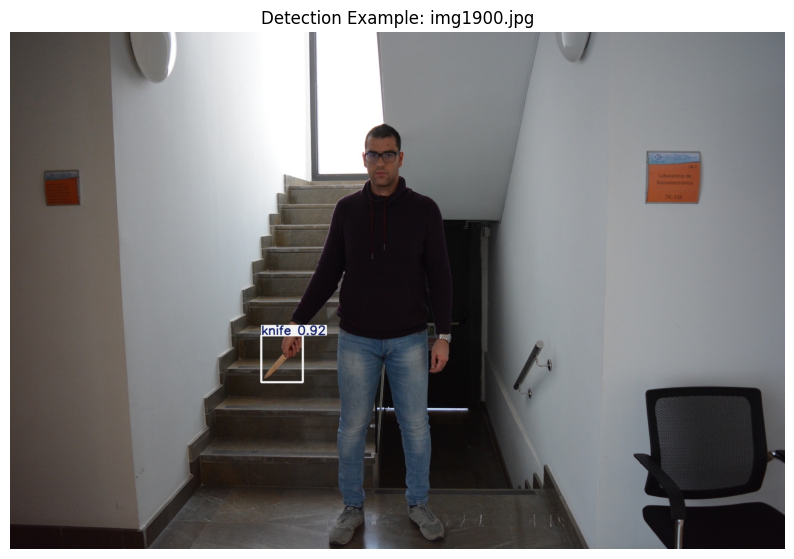

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Путь к изображению
image_path = "/content/yolov5/runs/detect/exp/DSC_0069.jpg"

# Загрузка изображения
img = Image.open(image_path)

# Отображение изображения
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Detection Example: img1900.jpg")
plt.axis('off')  # Отключение осей
plt.show()

## Сравнение исходной и оптимизированной моделей

Исходная модель:

In [ ]:
!yolo val \
    model=/content/models/model_8v.onnx \
    data=/content/dataset/dataset.yaml \
    name=original_val

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/models/models_8v.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider
2025-04-23 07:22:04.573070707 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3680.6±1116.8 MB/s, size: 318.4 KB)
val: Scanning /content/dataset/labels/test.cache... 830 images, 27 backgrounds, 0 corrupt: 100% 857/857 [00:00<?, ?it/s]
                 Class     Images  Instances      

Оптимизированная модель

In [ ]:
!yolo val \
    model=/content/models/model_8v_optimized_nz.onnx \
    data=/content/dataset/dataset.yaml \
    name=neuzip_val

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/models/model_8v_optimized.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2700.0±1336.2 MB/s, size: 715.2 KB)
val: Scanning /content/dataset/labels/test.cache... 830 images, 27 backgrounds, 0 corrupt: 100% 857/857 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 857/857 [00:19<00:00, 45.06it/s]
                   all        857        830      0.811      0.729      0.836      0.677
                pistol         80         80      0.793      0.815      0.881      0.707
            smartphone        130        130       0.93      0

## Вывод:
* Точность (mAP) идентична:
* mAP50: 0.836 (оба варианта)
* mAP50-95: 0.677 (оба варианта)
* Скорость инференса улучшилась:
Исходная модель: 11.1 мс на изображение
Оптимизированная: 8.8 мс на изображение (ускорение на ~20%)
Оптимизация дала практически идентичную точность при ускорении инференса, что критично для реальных задач

# Yolo 11

Обучаем модель версии Yolo 11

In [ ]:
!yolo train \
    model=yolo11n.pt \
    data=/content/dataset/dataset.yaml \
    epochs=30 \
    imgsz=640 \
    batch=-1 \
    device=0 \
    amp=True


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 5.35M/5.35M [00:00<00:00, 183MB/s]
Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/dataset/dataset.yaml, epochs=30, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=N

## Экспорт в ONNX

In [ ]:
!yolo export \
    model=/content/runs/detect/train/weights/best.pt \
    format=onnx \
    imgsz=640 \
    simplify=True \
    opset=12 \
    dynamic=False \

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.50...
ONNX: export success ✅ 2.3s, saved as '/content/runs/detect/train/weights/best.onnx' (10.1 MB)

Export complete (3.1s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/runs/detect/train/weights/best.onnx imgsz=640 data=/content/dataset/dataset.yaml  
Visualize:       https://netron.app
💡 Learn more at https://docs.ultralytics.com/modes/export


## Оптимизация Neuzip
Также, используя облачные сервер, оптимизируем модель

In [ ]:
!python model_optimization_neuzip.py /models/model_11v.onnx --output_model /path/to/optimized/model_11v_optimized_nz.onnx

## Сравнение исходной и оптимизированной модели

In [ ]:
!yolo val \
    model=/content/runs/detect/train/weights/model_11v.onnx \
    data=/content/dataset/dataset.yaml \
    name=original_val

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/runs/detect/train/weights/model_v11.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider
2025-04-23 10:12:57.928198045 [W:onnxruntime:, transformer_memcpy.cc:83 ApplyImpl] 4 Memcpy nodes are added to the graph main_graph for CUDAExecutionProvider. It might have negative impact on performance (including unable to run CUDA graph). Set session_options.log_severity_level=1 to see the detail logs before this message.
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2599.4±911.3 MB/s, size: 493.1 KB)
val: Scanning /content/dataset/labels/test.cache... 830 images, 27 backgrounds, 0 corrupt: 100% 857/857 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 857/857 [00:23<00:00, 36.82it/s]
                   all        857        830       0.79      0.781      0.834  

In [ ]:
!yolo val \
    model=/content/runs/detect/train/weights/model_11v_optimized.onnx \
    data=/content/dataset/dataset.yaml \
    name=original_val

Ultralytics 8.3.114 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Loading /content/runs/detect/train/weights/model_v11_optimized.onnx for ONNX Runtime inference...
Using ONNX Runtime CUDAExecutionProvider
Setting batch=1 input of shape (1, 3, 640, 640)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2821.6±863.9 MB/s, size: 246.1 KB)
val: Scanning /content/dataset/labels/test.cache... 830 images, 27 backgrounds, 0 corrupt: 100% 857/857 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 857/857 [00:21<00:00, 40.48it/s]
                   all        857        830       0.79      0.781      0.834      0.681
                pistol         80         80      0.784       0.85      0.889      0.691
            smartphone        130        130      0.919      0.701      0.859      0.738
                 knife        452        452       0.95      0.942      0.973      0.669
                wallet         65       

## Вывод:
Точность осталась неизменной:
* mAP50: 0.834 (оба варианта)
* mAP50-95: 0.681 (оба варианта)
* Скорость инференса улучшилась:
Исходная YOLOv11: 13.8 мс на изображение
Оптимизированная: 9.9 мс на изображение (ускорение на ~28%)

## Выводы по обеим моделям:
Вывод по результатам валидации YOLOv8 и YOLOv11

Сравнение метрик точности
YOLOv8:

* Оригинальная и оптимизированная модели полностью сохранили метрики (mAP50: 0.836, mAP50-95: 0.677).

* Классы knife (P=0.952, R=0.918) и bill (mAP50=0.907) показывают наилучшую детекцию.

* Wallet и card имеют более низкие показатели (mAP50: 0.688 и 0.701 соответственно).

YOLOv11:

* Оптимизация не повлияла на точность (mAP50: 0.834, mAP50-95: 0.681).

* Лучшие результаты у классов knife (P=0.95, R=0.942) и bill (mAP50=0.908).

* Wallet высокий recall (R=0.738).

**YOLOv11** после оптимизации достигает рекордного ускорения (28%)

**YOLOv8** демонстрирует прирост скорости


Оптимизированные модели потребляют меньше ресурсов, что позволяет использовать более дешёвые устройства без потери скорости

Ускорение инференса позволяет одновременно анализировать на 20–30% больше видеопотоков без апгрейда железа.

Оптимизированные модели позволяют запускать компьютерное зрение на более бюджетных устройствах.
